In [1]:
from nltk.stem import PorterStemmer
from collections import defaultdict
import re
import numpy as np
from numpy.linalg import svd
from math import log
import matplotlib.pyplot as plt

# Build an IR System

## Reading the corpus

The data I used is a collection of book's plots. The dataset contains the following information:
1. Wikipedia article ID
2. Freebase ID
3. Book title
4. Author
5. Publication date
6. Book genres (Freebase ID:name tuples)
7. Plot summary

In order to store each instance of the dataset let's define a class to represent the data. 

In [2]:
class Book:
    
    def __init__(self, wikipedia_idx, freebase_idx, title, author, date, genres, plot):
        self._wikipedia_idx = wikipedia_idx
        self._freebase_idx = freebase_idx
        self._title = title
        self._author = author
        self._date = date
        self._genres = genres
        self._plot = plot
        
    def get_text(self):
        # function that return the plot of the Book
        return self._plot
    
    def __repr__(self):
        return self._title + ', ' + self._author

Now let's define a function to import the data and create a corpus of `Book`s.

In [3]:
def read_corpus_of_books(filepath):
    corpus = [] # create an empty list
    with open(filepath) as f: 
        for row in f: # for each row
            wikipedia_idx, freebase_idx, title, author, date, genres, plot = row.split('\t') # split the row
            corpus.append(Book(wikipedia_idx, freebase_idx, title, author, date, genres, plot)) # create the Book and append it to the corpus list
    return corpus

## Inverted index

In order to minimize the variation prensent in the data we need to clean the texts. Hence I defined some functions to remove the punctuation and the useless white spaces, convert everything to lower-case, split the text into tokens and perform stemming. For this last operation I used the Porter Stemmer.\
Finally I wrapped everything up into a `clean` function.

In [4]:
def normalize(text):
    text_cleaned = re.sub(r"[^\w\s]", ' ', text) # remove punctuation
    text_cleaned = re.sub('\s+', ' ', text_cleaned) # remove white spaces
    text_cleaned = text_cleaned.lower() # convert to lowercase
    return text_cleaned

def tokenize(text):
    return text.split() # split the text into tokens

ps = PorterStemmer()
def stemming(tokens):
    return [ps.stem(token) for token in tokens] # perform stemming

def clean(text):
    # perform all the abovementioned operations
    normalized = normalize(text)
    tokenized = tokenize(normalized)
    return stemming(tokenized)

Based on the cleaned corpus, let's create an inverted index which associate to each term and to each document containing that term the number of times that the term appears in the document. In this way it will be faster to build the term-document matrix.

In [5]:
class InvertedIndex:
    
    def __init__(self, index):
        self._dictionary = index
    
    @classmethod
    def from_corpus(cls, corpus):
        # create inverted index: index[term][docid] = count
        index = defaultdict(dict)
        for docId, document in enumerate(corpus[:NUM_DOCUMENT]): # for each document
            tokens = clean(document.get_text()) # collect the cleaned tokens
            for token in tokens: # for each token
                try:
                    index[token][docId] += 1 # add the counter
                except KeyError:
                    index[token][docId] = 1 # or set the counter to 1
        return cls(index) # return the index
    
    def keys(self):
        # function to return the set of keys of the dictionary -> the terms of the index
        return self._dictionary.keys()
    
    def __getitem__(self, key):
        return self._dictionary[key]
        raise KeyError # the key is not present

## Term-document matrix

In order to perform the **Latent Semantic Indexing** we need to build the term-document matrix, that is the matrix in which each row correspond to a term and each column to a document and the value of each element is equal to some kind of weighting of the word in the document.\
I wrote a class that allows you to build the term-document from the corpus. You can also choose two different options for the words weighting:
- the Bag of Words: in which each element of the matrix is equal to the frequency of the term in the document
- the tf-idf: in which each element of the matrix is equal to the term frequency - inverse document frequency score for the term in the document

Here, after having built the term-document matrix, begins the crucial part of the **LSI**\
The `svd` function of the class performes the singular value decomposition. In this way we are able to extract the latent factors of the term-document matrix, which express the concepts of the texts.\
Performing SVD we obtain three matrices:
- **U**: term-concept matrix where each row represent how much each term is represented by a certain concept
- **$\Sigma$**: concept matrix, a diagonal matrix where each value represent the weight of a concept
- **V**: document-concept matrix where each row represent how much a document contains a certain concept

An important thing that can be done with SVD is reduce the space occupied by the original term-document matrix by reducing its rank. Using SVD we are able to minimize the error introduced by the approximation according to the Fobenius norm.\
Hence, given the term-document matrix $C$ of rank $r$, its SVD $U\Sigma V^T$ and fixed the rank of the approximation to $k < r$, we can compute the approximated matrix $C_k$ by zeroing out the smallest $r-k$ singular values. Thus there is no need to store the last $r-k$ columns of $U$ and the last $r-k$ rows of $V$. So we can rewrite everything as a truncated SVD $U_k \Sigma_k V_k^T$.\
This low rank approximation can be done by calling the function `low_rank_approximation` and passing the reduced rank to it.

In [6]:
class TermDocumentMatrix:
    
    def __init__(self, index, matrix, tfidf = False):
        self._index = index
        self._matrix = matrix
        self._tfidf = tfidf
    
    @classmethod
    def from_corpus(cls, corpus, tfidf = False):
        index = InvertedIndex.from_corpus(corpus) # create the inverted index
        C = np.zeros((len(index.keys()), NUM_DOCUMENT)) # create a data matrix with #words-by-#docs dimensions
        # fill the matrix
        for i, word in enumerate(sorted(index.keys())): # for each word in the vocabulary
            for d in index[word].keys(): # for each document in the index
                try:
                    value = index[word][d] # get the number of times the word appears in the document
                    if tfidf: # if we want to use tfidf
                        value *= log(NUM_DOCUMENT/len(index[word])) # multiply the term frequency for the inverse document frequency
                    C[i,d] = value # assign the value to the matrix element
                except KeyError: # if the word do not appear in the docuent
                    C[i,d] = 0 # assign the value 0 to the matrix element
        return cls(index, C, tfidf) # call class ctor
        
    def get_vocabulary(self):
        # function to get the vocabulary
        return sorted(self._index.keys())
        
    def svd(self):
        # function to perform sigular value decomposition
        return svd(self._matrix, full_matrices=False, compute_uv=True)
    
    def low_rank_approximation(self, k):
        U, sigma, Vt = svd(self._matrix, full_matrices=False, compute_uv=True) # perform the svd
        U_k = U[:, :k] # keep only the firsts k columns of the matrix U
        sigma_k = sigma[:k] # the firsts k singular values
        Vt_k = Vt[:k, :] # and the firsts k rows of the matrix V
        return U_k, sigma_k, Vt_k.T

## IR System

Starting from the approximated matrices we are able to build a vector space model where the base is made by the *pseudo-terms*.

In the vector space we can compute the similarity between two documents by computing the cosine-similarity between the two corresponding vectors. Since the angle formed by the vectors does not depend on their magnitude, we can normalize the document vectors $V(d_i)$ to unit vectors $v(d_i) = \frac{V(d_i)}{||V(d_i)||}$ and then compute the cosine similarity as $sim(d_1,d_2) = v(d_1)v(d_2) $

In this vetor space model we have to remap the query vector (unit vector with non-zero components corresponding to the query terms) in the space of concepts: $\hat{q} = \Sigma^{-1} U^T q$.\
Then we can find the answere to a query using the cosine similarity: $score(q, d_i) = sim(q, d_i)$.\
Since we are computing a similarity score we have a ranking of documents. Hence we can retrieve the $K$ most relevant documents.

Let's now put everything together to build the Information Retrieval System.

The `IRSystem` class allows you to build an information retrieval system starting from a corpus or loading it from some files and also to save it to some files.\
In addition it is possible to answere some free text queries by retreaving the $K$ most relevant documents.

In [7]:
class IRSystem:
    
    def __init__(self, corpus, vocabulary, U, sigma, V):
        self._corpus = corpus
        self._vocabulary = vocabulary
        self._U = U
        self._sigma = sigma
        self._V = V
        
    @classmethod
    def from_corpus(cls, corpus, k, tfidf = False):
        term_document_matrix = TermDocumentMatrix.from_corpus(corpus, tfidf) # build the term-document matrix
        vocabulary = term_document_matrix.get_vocabulary() # extract the vocabulary
        U, sigma, V = term_document_matrix.low_rank_approximation(k) # get the reduced matrices
        for i,v in enumerate(V): # normalize the vectors
            V[i] = v/np.linalg.norm(v)
        return cls(corpus, vocabulary, U, sigma, V) # call the class ctor
    
    @classmethod
    def load_ir(cls, path, corpus):
        # load the vocabulary from a text fie
        with open(path + 'vocabulary.txt') as f:
            vocabulary = f.read().splitlines()
        # read the matrices from some numpy files
        U = np.load(path + 'U_matrix.npy')
        sigma = np.load(path + 'sigma_array.npy')        
        V = np.load(path + 'V_matrix.npy')        
        return cls(corpus, vocabulary, U, sigma, V) # call the class ctor

    def save_ir(self, path):
        # save the vocabulary into a text file
        vocabulary_file = open(path + 'vocabulary.txt', "w")
        for word in self._vocabulary:
            vocabulary_file.write(word + "\n")
        vocabulary_file.close()               
        # save the matrices into numpy files
        np.save(path + 'U_matrix', self._U)
        np.save(path + 'sigma_array', self._sigma)        
        np.save(path + 'V_matrix', self._V)
    
    def map_query(self, q):
        Q = np.linalg.inv(np.diag(self._sigma)).dot(self._U.T).dot(q) # map the query vector into the pseudo-terms space
        return Q / np.linalg.norm(Q) # normalize it
    
    def build_query_vector(self, text):
        q = np.zeros(len(self._vocabulary)) # create a vector of len #words
        # fill that vector with counts
        tokens = clean(text) # collect the tokens
        for i, word in enumerate(self._vocabulary): # for each word in the vocabulary
            q[i] = tokens.count(word) # count how many times that word is appearing in the text
        return self.map_query(q) # remap the query into the pseudo-terms space
    
    def answere_query(self, text, k = 5):
        q = self.build_query_vector(text) # build the query vector
        scores = []
        for d in self._V: # for each document (= row of V)
            scores.append(np.dot(q,d)) # cosine similarity
        results = (-np.array(scores)).argsort()[:k] # extract argmax of top K     
        return [(self._corpus[idx], scores[idx]) for idx in results], results # return the documents, their scores and theri idxs

Finally let's define a function to answer a free text query given the information retrieval system

In [8]:
def query(ir, text, k = 5, verbose = True):
    results, idxs= ir.answere_query(text, k) # extract the results to the query
    if verbose:
        for document in results: # print the results
            print(document)
    return idxs # return the idxs

# Let's do this

Let's now try to build the system and ask it some queries

In [9]:
NUM_DOCUMENT = 1000 # let's consider only the first 1000 documents (for RAM problems)

In [10]:
corpus = read_corpus_of_books('./booksummaries/booksummaries.txt') # read the corpus 

In [11]:
ir = IRSystem.from_corpus(corpus, 100) # build the ir sysrem

In [12]:
query(ir, 'animal england rebellion', 5) # ask a query

(Animal Farm, George Orwell, 0.8055658403862466)
(Guns, Germs, and Steel, Jared Diamond, 0.49004279852382604)
(Charlotte's Web, E. B. White, 0.3373472459954793)
(Interview with the Vampire, Anne Rice, 0.2995314032866505)
(The Quiet Earth, Craig Harrison, 0.29893781427874455)


array([  0, 382, 792, 329, 523])

In [13]:
ir.save_ir('./data/first_ir/') # save the ir

In [14]:
# load the ir from file
corpus2 = read_corpus_of_books('./booksummaries/booksummaries.txt')
ir2 = IRSystem.load_ir('./data/first_ir/', corpus2)

## Also with tf-idf matrix

Let's try to build the system using the term frequency - inverse document frequency weighting

In [15]:
ir_tfidf = IRSystem.from_corpus(corpus, 100, True) # build the ir sysrem

In [16]:
query(ir_tfidf, 'animal england rebellion', 5) # ask a query

(The BFG, Roald Dahl, 0.5771182775117198)
(The Sword in the Stone, T. H. White, 0.5598294692529134)
(Uncle Cleans Up, , 0.504141365273493)
(The Ugly Duckling, Hans Christian Andersen, 0.49847816701955405)
(The Chrysalids, John Wyndham, 0.49397025027304564)


array([663, 536, 617, 774, 737])

Executing the queries in this way we can see that the results seem to be coherent with the asked query. Nevertheless we do not have a way to numerically evaluate the performances of the information retrieval system.

# Evaluation

To evaluate the information retrieval system let's consider another dataset: the *Cranfield collection*

## Cranfield articles

The Cranfield collection contains 1398 abstracts of aerodynamics journal articles, each of them is composed by:
1. idx: a univocal index
2. title: the tile of the article
3. text: the text of the article

In order to store each instance let's define a class to represent the data.

In [17]:
class Articles:
    
    def __init__(self, idx, title, text):
        self._idx = idx
        self._title = title
        self._text = text
    
    def get_text(self):
        # function to get the text of the ariticle
        return self._text
    
    def get_idx(self):
        # function to get the idx of the article
        return self._idx
    
    def __repr__(self):
        return self._idx + ': ' + self._title  

And a function to read them and create a corpus of `Articles`.

In [18]:
def read_Cranfield(filepath):
    with open(filepath) as f: # open the file
        corpus = []
        is_title = False
        is_text = False
        text = ""
        title = ""
        for row in f: # for each row
            if row.startswith(".A"): # if it starts with .A
                is_title = False # the tile is ended
            elif row.startswith(".I"): # if it starts with .I
                is_text = False # the text is ended
                if text != "":
                    corpus.append(Articles(idx, title.replace('\n', ' '), text.replace('\n', ' '))) # create an Article instance
                    title = ""
                    text = ""
                idx = re.findall('[0-9]+', row)[0] # extract the index from the row
            if is_title: # if we are reading the title
                title += row # concat it
            if is_text: # if we are reading the text
                text += row # concat it
            if row.startswith(".T"): # if it starts with .T
                is_title = True # we are going to read the title in the next lines
            elif row.startswith(".W"): # if it starts with .W
                is_text = True # we are going to read the text in the next lines
    return corpus # return the corpus

# Cranfield queries and relevance set

The Cranfield collection also contains a set of 225 queries, and exhaustive relevance judgments of all (query, document) pairs.\
Hence each query has:
1. idx: a univocal index
2. text: the text of the query
3. relevance_set: the list of relevant document for the query

In order to store each instance let's define a class to represent the data.\
The class has also some function to evaluate the results of the query by comparing the list of retrieved documents with the relevant ones.

In [19]:
class Query:
    
    def __init__(self, idx, text, relevance_set):
        self._idx = idx
        self._text = text
        self._relevance_set = relevance_set
        
    def evaluate(self, docs_idx):
        # function to visually evaluate the performances relative query: True if the document is relevant for it, False otherwise
        return [idx in self._relevance_set for idx in docs_idx]   
    
    def precision(self, docs_idx):
        # function to compute the precision relative to a query
        return sum([int(idx in self._relevance_set) for idx in docs_idx])/len(docs_idx)
    
    def recall(self, docs_idx):
        # function to compute the recall relative to a query
        return sum([int(idx in self._relevance_set) for idx in docs_idx])/len(self._relevance_set)
        
    def get_query(self):
        # function to get the text of a query
        return self._text
    
    def get_num_relevant_docs(self):
        # function to get the number of relevant documents for a query
        return len(self._relevance_set)
    
    def __repr__(self):
        return self._idx + ': ' + self._text 

Let's also define a funciton to read the relevance set

In [20]:
def read_relevance(filepath):
    with open(filepath) as f:
        relevance_set = {}
        for row in f: # for each row
            l = re.findall('[0-9]+', row) # extract the numbers
            q = l[0] # the first one is the query id
            doc = l[1] # the second one is the document id
            try:
                relevance_set[q].append(doc) # append the document id to the relevance set
            except KeyError:
                relevance_set[q] = [doc] # or initialize the set
    return relevance_set # return the relevance set

And to read the queries and create a corpus of `Query`

In [21]:
def read_queries(filepath, relevance_set):
    with open(filepath) as f:
        corpus = []
        is_text = False
        text = ""
        i = 1
        for row in f: # for each row
            if row.startswith(".I"): # if it starts with .I
                is_text = False # the text is ended
                if text != "":
                    corpus.append(Query(idx, text.replace('\n', ' '), relevance_set[str(i)])) # create a Query instance
                    i += 1
                    text = ""
                idx = re.findall('[0-9]+', row)[0] # extract the idx of the query
            if is_text: # if we are reading the text
                text += row # concat it
            elif row.startswith(".W"): # if it starts with .W
                is_text = True # we are going to read the text in the next lines
    return corpus # return the corpus

## Evaluation functions

Let's now define various functions to evaluate the performances of the information retrieval system
- **Precision-recall curve**: compute precision and recall for the first 1, 2, 3, 4, ..., R retrieved documents (where R is the number of relevant documents for the considered query), compute the interpolated precision and plot them
- **R-precision**: If there are R relevant documents for a query, the R-precision is the precision of the top R ranked documents returned by the query. R-precision can be averaged across queries
- **Mean Average Precision**: $= \frac 1 n \sum_{j=1}^n(\frac 1 {m_j} \sum_{k=1}^{m_j} Precision(R_{kj}))$ where $n$ is the number of considered queries, $m_j$ is the number of relevant documents for the j-th query and $R_{kj}$ is the set of ranked documents retrieved for the j-th query that we get to obtain k relevant documents

In [22]:
def precision_recall_curve(ir, q, corpus):
    results = query(ir, q.get_query(), q.get_num_relevant_docs(), False) # extract the R most relevant documents for the query
    docs_idx = [corpus[idx].get_idx() for idx in results] # extract their idxs in the corpus
    precision = []
    recall = []
    for j in range(1, q.get_num_relevant_docs()+1): # considering the first j retrieved documents
        precision.append(q.precision(docs_idx[:j])) # compute the precision
        recall.append(q.recall(docs_idx[:j])) # and the recall
    # compute the interpolated precision
    interpolated_precision = []
    for i in range(len(precision)): 
        interpolated_precision.append(max(precision[i:]))
    # and plot everything
    fig, ax = plt.subplots()
    ax.plot(recall, precision)
    ax.plot(recall, interpolated_precision, ':')
    ax.set(xlabel='recall', ylabel='precision',
           title='Recall-precision curve')
    plt.show()
    return precision, recall # return precision and recall

In [23]:
def R_precision(ir, q, corpus):
    results = query(ir, q.get_query(), q.get_num_relevant_docs(), False) # extract the R most relevant documents for the query  
    docs_idx = [corpus[idx].get_idx() for idx in results] # extract their idxs in the corpus
    return q.precision(docs_idx) # compute precision

In [24]:
def mean_R_precision(ir, queries_set, corpus):
    mean_r = 0
    for q in queries_set: # for each query in the set
        mean_r += R_precision(ir, q, corpus) # compute R precision
    return mean_r/len(queries_set) # and compute the mean value

In [25]:
def average_precision(ir, q, corpus):
    sum_of_precisions = 0
    results = query(ir, q.get_query(), q.get_num_relevant_docs(), False) # extract the R most relevant documents for the query 
    docs_idx = [corpus[idx].get_idx() for idx in results] # extract their idxs
    for j in range(1, q.get_num_relevant_docs()+1): # considering the first j retrieved documents
        sum_of_precisions += q.precision(docs_idx[:j]) # compute the precision 
    return sum_of_precisions/q.get_num_relevant_docs() # return average precision of the query q

In [26]:
def mean_average_precision(ir, queries_set, corpus):
    sum_average_precisions = 0
    for q in queries_set: # for each query in the set
        sum_average_precisions += average_precision(ir, q, corpus) # compute average precision of the query q
    return sum_average_precisions/len(queries_set) # return MAP

## Let's evaluate

Let's build the information retrieval system on the new corpus.

In [27]:
# import data
cranfield_corpus = read_Cranfield('./cranfield/cran.all.1400')
relevance_set = read_relevance('./cranfield/cranqrel')
queries_corpus = read_queries('./cranfield/cran.qry', relevance_set)

In [28]:
NUM_DOCUMENT = len(cranfield_corpus) # cosider all the corpus

In [29]:
# create the information retrieval system
cranfield_ir = IRSystem.from_corpus(cranfield_corpus, 200)

First of all let's consider the first query of the corpus and evaluate the results on it

In [30]:
q = queries_corpus[0]
print(q.get_query())

what similarity laws must be obeyed when constructing aeroelastic models of heated high speed aircraft . 


In [31]:
query(cranfield_ir, q.get_query())

(51: theory of aircraft structural models subjected to aerodynamic heating and external loads . , 0.4466336639784838)
(486: similarity laws for aerothermoelastic testing . , 0.3989268108596872)
(184: scale models for thermo-aeroelastic research . , 0.36404196218126833)
(12: some structural and aerelastic considerations of high speed flight . , 0.34560867049063276)
(435: application of similar solutions to calculations of laminar heat transfer on bodies with yaw and large pressure gradients in high speed flow . , 0.29471286730803)


array([ 50, 484, 183,  11, 434])

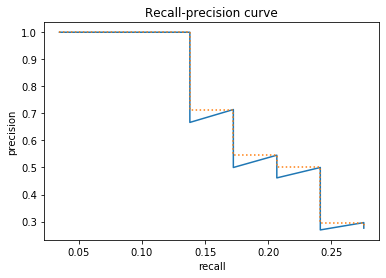

In [32]:
# precision-recall curve
precision, recall = precision_recall_curve(cranfield_ir, q, cranfield_corpus)

In [33]:
# R-precision
R_precision(cranfield_ir, q, cranfield_corpus)

0.27586206896551724

To have a better overview of the performances let's now consider the first 10 queries of the corpus and evaluate the average results on them

In [34]:
queries_set = [queries_corpus[x] for x in range(10)]
[x.get_query() for x in queries_set]

['what similarity laws must be obeyed when constructing aeroelastic models of heated high speed aircraft . ',
 'what are the structural and aeroelastic problems associated with flight of high speed aircraft . ',
 'what problems of heat conduction in composite slabs have been solved so far . ',
 'can a criterion be developed to show empirically the validity of flow solutions for chemically reacting gas mixtures based on the simplifying assumption of instantaneous local chemical equilibrium . ',
 'what chemical kinetic system is applicable to hypersonic aerodynamic problems . ',
 'what theoretical and experimental guides do we have as to turbulent couette flow behaviour . ',
 'is it possible to relate the available pressure distributions for an ogive forebody at zero angle of attack to the lower surface pressures of an equivalent ogive forebody at angle of attack . ',
 'what methods -dash exact or approximate -dash are presently available for predicting body pressures at angle of attack.

In [35]:
# mean R-precision
mean_R_precision(cranfield_ir, queries_set, cranfield_corpus)

0.23736398467432948

In [36]:
# mean average precision
mean_average_precision(cranfield_ir, queries_set, cranfield_corpus)

0.37552082278824295

## And again with tf-idf weighting

Let's do the same operation using the term frequency - inverse document frequency weighting

In [37]:
# create the information retrieval system
cranfield_ir_tfidf = IRSystem.from_corpus(cranfield_corpus, 200, True)

In [38]:
query(cranfield_ir_tfidf, q.get_query())

(51: theory of aircraft structural models subjected to aerodynamic heating and external loads . , 0.6116681195058333)
(184: scale models for thermo-aeroelastic research . , 0.4429827613312155)
(12: some structural and aerelastic considerations of high speed flight . , 0.425944004334774)
(253: on the ground level disturbance from large aircraft flying at supersonic speeds . , 0.3743410752224686)
(13: similarity laws for stressing heated wings . , 0.3495825346622867)


array([ 50, 183,  11, 252,  12])

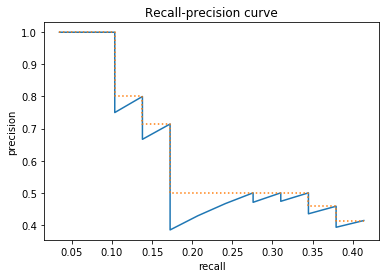

In [39]:
precision, recall = precision_recall_curve(cranfield_ir_tfidf, q, cranfield_corpus)

In [40]:
R_precision(cranfield_ir_tfidf, q, cranfield_corpus)

0.41379310344827586

In [41]:
mean_R_precision(cranfield_ir_tfidf, queries_set, cranfield_corpus)

0.40904597701149426

In [42]:
mean_average_precision(cranfield_ir_tfidf, queries_set, cranfield_corpus)

0.48817172924737695

The performances are a much better when using the term frequency - inverse document frequency to build the term document matrix!\
Hence, form now on, let's only consider this matrix.

## Fine tune

Thanks to the abovementioned metrics we can now tune the rank of the low-rank approximation in order to obtain better results.

Let's consider both the *mean R-precision*  and the *mean average precision* and let's see how their performnces change when the rank of the approximation change.\
The value of the rank *k* will vary from 100 to 800 by steps of 10. The queries that will be used in the evaluation are the first 10 of the corpus.

Rank  100 :  0.2672605363984674 ;  0.406961124494155
Rank  200 :  0.40904597701149426 ;  0.48817172924737695
Rank  300 :  0.41936398467432945 ;  0.5325708979255441
Rank  400 :  0.3941455938697318 ;  0.5771374120431949
Rank  500 :  0.35937164750957856 ;  0.543615176215534
Rank  600 :  0.3453639846743295 ;  0.5327937553951932
Rank  700 :  0.3379157088122605 ;  0.4995535880013344


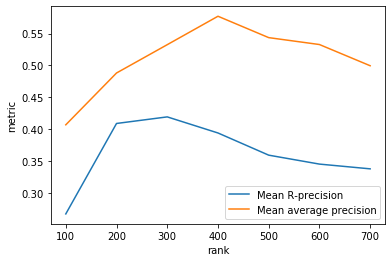

In [43]:
mRp = []
mAp = []
for k in range(100,800, 100):
    cranfield_ir_tfidf = IRSystem.from_corpus(cranfield_corpus, k, True) # create the ir  
    mRp.append(mean_R_precision(cranfield_ir_tfidf, queries_set, cranfield_corpus)) # compute mean R precision
    mAp.append(mean_average_precision(cranfield_ir_tfidf, queries_set,cranfield_corpus)) # compute mean average precision
    print('Rank ', k, ': ', mRp[-1], '; ', mAp[-1])

# plot
fig, ax = plt.subplots()
ax.plot(range(100,800, 100), mRp, label = 'Mean R-precision')
ax.plot(range(100,800, 100), mAp, label = 'Mean average precision')
ax.set(xlabel='rank', ylabel='metric')
ax.legend()
plt.show()

We can see that both the metrics reach a maximum and then decrease. Both of them perform well when the rank in $400$. Hence let's rebuilt the information retrieval system specifying a rank of $400$ for the approximation.

In [44]:
cranfield_ir_tfidf = IRSystem.from_corpus(cranfield_corpus, 400, True)

Let's try the very first query of the Cranfield collection again

In [45]:
query(cranfield_ir_tfidf, q.get_query())

(51: theory of aircraft structural models subjected to aerodynamic heating and external loads . , 0.4264233649710893)
(359: note on the hypersonic similarity law for an unyawed cone . , 0.30833826118955276)
(184: scale models for thermo-aeroelastic research . , 0.3015635625182126)
(435: application of similar solutions to calculations of laminar heat transfer on bodies with yaw and large pressure gradients in high speed flow . , 0.2857866661895783)
(56: an analysis of the applicability of the hypersonic similarity law to the study of the flow about bodies of revolution at zero angle of attack . , 0.283156018624507)


array([ 50, 358, 183, 434,  55])

We can see that the ranking of the documents is changed a bit with respect to the $200$ dimensions approximation. In addition the scores are a bit lower then before.

Let's also compute the basic metrics again

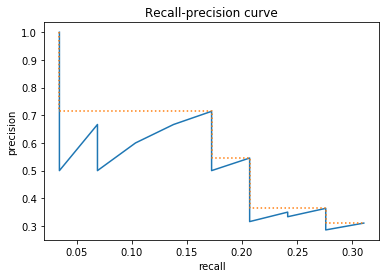

In [46]:
# precision recall curve
precision, recall = precision_recall_curve(cranfield_ir_tfidf, q, cranfield_corpus)

In [47]:
# R-precision
R_precision(cranfield_ir_tfidf, q, cranfield_corpus)

0.3103448275862069

We can see that these metrics does not imporve with respect to the $200$ dimensions approximation but, on the contrary, it worsen. 

To have a better understending let's now recompute the performances on the set of 10 queries defined above.

In [48]:
# mean R-precision
mean_R_precision(cranfield_ir_tfidf, queries_set, cranfield_corpus)

0.3941455938697318

In [49]:
# mean average precision
mean_average_precision(cranfield_ir_tfidf, queries_set, cranfield_corpus)

0.5771374120431949

As seen above the mean R precision is almost the same as the one obtained with the 200 rank approximation. Nevertheless the mean average precision is much better then before.